# Reading, writing, and visualizing *.isq* files

This notebook was created with the support of [SPECTRA](https://www.spectra-collab.org/)

Content under Creative Commons license CC-BY-NC-SA 4.0   
Code under GNU-GPL v3 License  
By [Serena Bonaretti](https://sbonaretti.github.io/)
---

This notebook contains code for:   
[1. Reading *.isq* file headers](#1)  
&nbsp;&nbsp;&nbsp; [1.1. Getting the names of the *.isq* files in a folder](#1.1)  
&nbsp;&nbsp;&nbsp; [1.2 Extracting information from image headers](#1.2)  
[2. Creating a metadata table](#2)   
&nbsp;&nbsp;&nbsp; [2.1 Getting image metadata from image headers](#2.1)  
&nbsp;&nbsp;&nbsp; [2.2 Getting subject metadata and other metadata from a tabular file](#2.2)  
&nbsp;&nbsp;&nbsp; [2.3 Merging the metadata tables](#2.3)  
[3. Saving the table to a *.csv* or *.xlsx* file](#3)    
[4. Reading a *.isq* image](#4)  
[5. Saving an image to *.mha* with its *.isq* header](#5)   
[6. Reading an image and its header from a *.mha* file](#6)   
[7. Visualizing images](#7)  
&nbsp;&nbsp;&nbsp; [7.1 Visualizing one slice of one image](#7.1)  
&nbsp;&nbsp;&nbsp; [7.2 Browings an image with a slider](#7.2)  
&nbsp;&nbsp;&nbsp; [7.3 Visualizing three slices for several images](#7.3)  
[8. Hints](#8)  
[9. Dependencies](#9)

--- 
## Installing packages (only the first time)

In this notebook we use:
- Python scientific packages (i.e. matplotlib and pandas), which are part of anaconda (download anaconda [here](https://www.anaconda.com/products/individual))  
- Specific packages:  
    - [pymsk](https://github.com/JCMSK/pyMSK), which contains functions to read, write, and visualize *.isq* files. It also installs [SimpleITK](https://simpleitk.readthedocs.io/en/master/#) and [ITK](https://itk.org/)  
    - [itk-ioscanco](https://github.com/KitwareMedical/ITKIOScanco), to read *.isq* images
    - [watermark](https://github.com/rasbt/watermark), to print out the notebook dependencies for future reproducibility   

In the following cell, the `!`  tells the notebook to execute terminal commands (so no need to open a terminal separately)  
The following cell must be run only the very first time we use this notebook to install the packages. For the following times, we can comment out the cell by adding `#` in front of each command


In [ ]:
#! pip install pymsk
#! python -m pip install itk-ioscanco
#! pip install watermark
#! pip install wget

---
Imports:

In [1]:
# python imports
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import wget

# medical image imports
from pymsk import scanco_read_files
from pymsk import scanco_viz
from pymsk import write_files
import SimpleITK as sitk

---
## Input data

You can either use images we provide (see a.) or your own images (see b.)

### a. If you are using given data

Create a local folder:

In [2]:
# local folder  
isq_folder = "./iqs_data/"

# create folder
if not os.path.isdir(isq_folder):
    os.mkdir(isq_folder)

Download images and *subjects_data.csv* from Zenodo (it might take a few minutes):   

In [3]:
# Zenodo url and file names
zenodo_url             = "https://zenodo.org/record/4073082/files/" # 4073082 is in the DOI 
image_file_names       = ["C0000221.ISQ", "C0000222.ISQ"]
subject_data_file_name = "subjects_data.csv"

# download images from Zenodo
for file_name in image_file_names:
    wget.download(zenodo_url + file_name, isq_folder + file_name)

# download subjects_data from Zenodo
wget.download(zenodo_url + subject_data_file_name, isq_folder + subject_data_file_name)

'./iqs_data/subjects_data.csv'

---
### b. If you are using your own data:

Add the image directory and the subject_data_file_name here:

In [ ]:
isq_folder             = " " # write here your path. Make sure it terminates with "/"
subject_data_file_name = " " # write here the name of your tabular file

--- 
<a class="anchor" id="1"></a>
## 1. Reading *.isq* file headers

<a class="anchor" id="1.1"></a>
### 1.1. Getting the names of the *.isq* files in a folder:

In [4]:
# getting the folder content
folder_content = os.listdir(isq_folder)

# creating the list for .isq file names
isq_file_names = [] 

# getting only .isq files
for i in range(0, len(folder_content)): 
    
    # getting file extensions
    filename, file_extension = os.path.splitext(isq_folder + folder_content[i])
    
    # get only the files with .isq or .ISQ file extension
    if "isq" in file_extension or "ISQ" in file_extension:
        isq_file_names.append(folder_content[i])
        
print ("-> Found " + str(len(isq_file_names)) + " .isq files in folder:" )
for filename in isq_file_names:
    print (filename)

-> Found 2 .isq files in folder:
C0000221.ISQ
C0000222.ISQ


<a class="anchor" id="1.2"></a>
### 1.2 Extracting information from image headers  

- To read the .isq file headers, we use the function `read_isq_header()` from `pymsk`  
- For each image, we will get two lists: 
    - `keys`, containing all the information labels (e.g. *pixel_size_um*, etc.)
    - `values`, containing all the actual values (e.g. *82*, etc.)  
- Then we save the `keys` of the first image into the list `all_keys` - we do not need to save the keys for every image because they are the same   
  The values in `all_keys` will become the column names of the table
- Finally for each image we add the list `values` to the list of lists `all_values`  
  The values in `all_values` will become the content of the table

In [5]:
# initializing list containing keys and values
all_keys = []
all_values = []

# for each .isq file in the folder
for i in range(0, len(isq_file_names)): 
       
    # get keys and values from the header of the current image
    current_keys, current_values = scanco_read_files.read_isq_header(isq_folder + isq_file_names[i]) 

    # save the keys of the first image in the variable all_keys
    if i == 0:
        all_keys = current_keys

    # add the values of the current image header into all_values
    all_values.append(current_values)

--- 
<a class="anchor" id="2"></a>
## 2. Creating a metadata table 

- We want to create a metadata table containing:  
  - Image metadata from *.isq* headers  
  - Subject metadata and other metadata collected by an operator in a tabular file (e.g. *.csv*)  
  
  
- To handle tables, we use the python package [pandas](https://pandas.pydata.org/), imported at the beginning of the notebook

<a class="anchor" id="2.1"></a>
### 2.1 Getting image metadata from image headers

- First we create the image metadata table where:  
  - `all_keys` will be the table column names 
  - `all_values` will be the content of the table    
- Then we insert a column at the beginning of the table containing the image file names for reference    
- Finally we drop the column *fill* as it just contains zeros

In [6]:
# display all pandas columns and rows 
pd.options.display.max_rows    = None
pd.options.display.max_columns = None

In [7]:
# create dataframe (=table)
isq_headers = pd.DataFrame(all_values, columns = all_keys)

# adding column with file names in position 0
isq_headers.insert(0, "file_name", isq_file_names)

# delete column "fill" because it just contains zeros
isq_headers = isq_headers.drop(columns = ["fill"])

# show dataframe
isq_headers

,file_name,check,data_type,nr_of_bytes,nr_of_blocks,pat_no,scanner_id,date,n_voxels_x,n_voxels_y,n_voxels_z,total_size_um_x,total_size_um_y,total_size_um_z,slice_thickness_um,pixel_size_um,slice_1_pos_um,min_intensity,max_intensity,mu_scaling,nr_of_samples,nr_of_projections,scan_dist_um,scanner_type,exposure_time,meas_no,site,reference_line_um,recon_algo,pat_name,energy_V,intensity_uA,data_offset
0,C0000221.ISQ,CTDATA-HEADER_V1,3,585105920,1142785,39,3314,2006_05_01,1536,1536,110,125952,125952,9020,82,82,116811,-1958,11040,8192,1536,750,125952,9,100000,189,20,0,3,Normal Volunteer Study; 009 Radius,59400,1000,5
1,C0000222.ISQ,CTDATA-HEADER_V1,3,585105920,1142785,40,3314,2006_05_01,1536,1536,110,125952,125952,9020,82,82,119037,-2399,12927,8192,1536,750,125952,9,100000,190,38,0,3,Normal Volunteer Study; 009 Tibia,59400,1000,5


<a class="anchor" id="2.2"></a>
### 2.2 Getting subject metadata and other metadata from a tabular file

- We read the tabular file `subject_data` containing information about subjects and acquision protocol. Find a template [here](https://github.com/JCMSK/nb_gallery/blob/master/data/tabular/subjects_scanco_template.csv)  

In [8]:
# read the table
subject_data = pd.read_csv(isq_folder + subject_data_file_name)
subject_data

,scanner_id,meas_no,laterality,dominant hand,acquisition time (months),protocol ID,pat_age,pat_gender,pat_ethnicity,OA stage
0,3314,189,L,yes,0,001_abc,60,F,Asian,1
1,3314,190,L,yes,6,002_abc,65,M,Caucasian,2


<a class="anchor" id="2.3"></a>
### 2.3 Merging the metadata tables

Finally, we create a `metadata` table that is the combination of `isq_headers` and `subject_data`. We do the merge by using `scanner_id` and `meas_no` as keys  

In [9]:
# add the subject data to 
metadata = pd.merge(isq_headers, subject_data, on=["scanner_id", "meas_no"])
metadata

,file_name,check,data_type,nr_of_bytes,nr_of_blocks,pat_no,scanner_id,date,n_voxels_x,n_voxels_y,n_voxels_z,total_size_um_x,total_size_um_y,total_size_um_z,slice_thickness_um,pixel_size_um,slice_1_pos_um,min_intensity,max_intensity,mu_scaling,nr_of_samples,nr_of_projections,scan_dist_um,scanner_type,exposure_time,meas_no,site,reference_line_um,recon_algo,pat_name,energy_V,intensity_uA,data_offset,laterality,dominant hand,acquisition time (months),protocol ID,pat_age,pat_gender,pat_ethnicity,OA stage
0,C0000221.ISQ,CTDATA-HEADER_V1,3,585105920,1142785,39,3314,2006_05_01,1536,1536,110,125952,125952,9020,82,82,116811,-1958,11040,8192,1536,750,125952,9,100000,189,20,0,3,Normal Volunteer Study; 009 Radius,59400,1000,5,L,yes,0,001_abc,60,F,Asian,1
1,C0000222.ISQ,CTDATA-HEADER_V1,3,585105920,1142785,40,3314,2006_05_01,1536,1536,110,125952,125952,9020,82,82,119037,-2399,12927,8192,1536,750,125952,9,100000,190,38,0,3,Normal Volunteer Study; 009 Tibia,59400,1000,5,L,yes,6,002_abc,65,M,Caucasian,2


---
<a class="anchor" id="3"></a>
## 3. Saving the table to a *.csv* or *.xlsx* file  

We can save the dataframe to several different file formats. Here we save it as:  
- *.csv* (open source)
- *.xlsx* (proprietary)  


In [10]:
# save to csv
metadata.to_csv(isq_folder + "metadata.csv")

# save to excel
metadata.to_excel(isq_folder + "metadata.xlsx")

---
<a class="anchor" id="4"></a>
## 4. Reading a *.isq* image

To read an image, we use the function `read_isq_image()` from `pymsk`, where:   
- The argument of the function is the image file name  
- The returned image is a SimpleITK image

In [11]:
# define the ID of the image we are going to read
img_ID = 0

In [12]:
# read the image
img = scanco_read_files.read_isq_image(isq_folder + isq_file_names[img_ID])

In [13]:
# print out the usual SimpleITK image characteristics
print (img.GetSize())
print (img.GetSpacing())
print (img.GetOrigin())
print (img.GetDirection())

(1536, 1536, 110)
(0.082, 0.082, 0.08199999999999999)
(0.0, 0.0, 0.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


- It can take some time to read *.isq* images as they can be big. To know the reading time:

In [14]:
# start the timer
start_time = time.time()

# read the image
img = scanco_read_files.read_isq_image(isq_folder + isq_file_names[img_ID])

# stop the timer and print out 
print("Reading the image took " + "{:.2f}".format(time.time() - start_time) + " seconds")

Reading the image took 2.14 seconds


---
<a class="anchor" id="5"></a>
## 5. Saving an image to *.mha* with its *.isq* header

To save an image, we use the function `write_mha_image()` from `pymsk`, where the arguments are:  
- the image  
- image file name  
- metadata keys. This is an *optional* argument. 
- metadata values. This is an *optional* argument.  

The image is saved as a *.mha* file

In this example we save the image all its metadata

In [15]:
# preparing the arguments

# image file name: substituting .isq with .mha
root, ext = os.path.splitext(isq_file_names[img_ID])
mha_file_name = root + ".mha"

# the image keys are the column names of the dataframe, transformed into a list
img_keys = list(metadata.columns)

# the image values are in a row corresponding to the image ID (note that IDs start from zero)
img_values = list(metadata.loc[img_ID,:])

In [16]:
# writing the image
write_files.write_mha_image(img, mha_file_name, img_keys, img_values)

In [17]:
# writing the image with no metadata in the header (not recommended)
# write_files.write_mha_image(img, mha_file_name) # uncomment the command by deleting # at the beginning of the line

---
<a class="anchor" id="6"></a>
## 6. Reading an image and its header from a *.mha* file  

Once we have saved the *.isq* file as a *.mha* file, we might want to reload it for subsequent analysis maybe into another notebook or pipeline. The image that we read will be a *SimpleITK* image, so that we can use *SimpleITK* functions to process and analyze it. Here are the *SimpleITK* commands:

In [18]:
# reading the image
img = sitk.ReadImage(mha_file_name)

In [19]:
# print out the header of the image
for key in img.GetMetaDataKeys():
        print("\"{0}\":\"{1}\"".format(key, img.GetMetaData(key)))

"ITK_InputFilterName":"MetaImageIO"
"OA stage":"1"
"acquisition time (months)":"0"
"check":"CTDATA-HEADER_V1"
"data_offset":"5"
"data_type":"3"
"date":"2006_05_01"
"dominant hand":"yes"
"energy_V":"59400"
"exposure_time":"100000"
"file_name":"C0000221.ISQ"
"intensity_uA":"1000"
"laterality":"L"
"max_intensity":"11040"
"meas_no":"189"
"min_intensity":"-1958"
"mu_scaling":"8192"
"n_voxels_x":"1536"
"n_voxels_y":"1536"
"n_voxels_z":"110"
"nr_of_blocks":"1142785"
"nr_of_bytes":"585105920"
"nr_of_projections":"750"
"nr_of_samples":"1536"
"pat_age":"60"
"pat_ethnicity":"Asian"
"pat_gender":"F"
"pat_name":"Normal Volunteer Study; 009 Radius"
"pat_no":"39"
"pixel_size_um":"82"
"protocol ID":"001_abc"
"recon_algo":"3"
"reference_line_um":"0"
"scan_dist_um":"125952"
"scanner_id":"3314"
"scanner_type":"9"
"site":"20"
"slice_1_pos_um":"116811"
"slice_thickness_um":"82"
"total_size_um_x":"125952"
"total_size_um_y":"125952"
"total_size_um_z":"9020"


In [20]:
# print out the usual SimpleITK image properties
print (img.GetSize())
print (img.GetSpacing())
print (img.GetOrigin())
print (img.GetDirection())

(1536, 1536, 110)
(0.082, 0.082, 0.08199999999999999)
(0.0, 0.0, 0.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


--- 
<a class="anchor" id="7"></a>
## 7. Visualizing images   

Before visualizing an image, we can determine the figure dimension using the command below:

In [21]:
 plt.rcParams['figure.figsize'] = [5, 5] # the values are in inches

*Note:* Figure dimensions remain constant throughout the whole notebook. To change the dimensions of a following figure, copy/paste the previous command with the new dimensions right above the new figure

Here are some common ways to visualize images:

<a class="anchor" id="7.1"></a>
### 7.1 Visualizing one slice of one image

To visualize one image slice we use the function `show_sitk_slice()` from `pymsk`. It can have three arguments:  
- `img`: a *SimpleITK* image. It is a *mandatory* argument 
- `slice_id`: id of the slice to visualize. It is an *optional* argument. If not specified, the function shows the slice in the middle of the stack  
- `plane`: plane to visualize. The directions are with respect to the scanner gantry. It is an *optional* argument with three options:  
   - `"a"`, for *axial* 
   - `"v"`, for *vertical* 
   - `"h"`, for *horizontal*     
   
 If not specified, the function shows the slice in the axial plane.   
 More information on planes for *.isq* images in *SimpleITK* and *Numpy* [here](https://github.com/JCMSK/pyMSK/blob/master/doc/img/isq_image_directions.pdf)

Showing a slice with default parameters:

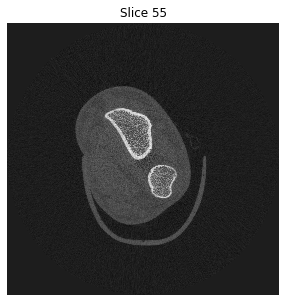

In [22]:
scanco_viz.show_sitk_slice(img) 

Showing a slice with specified parameters:

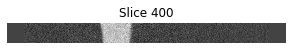

In [23]:
scanco_viz.show_sitk_slice(img, slice_id = 400, plane = "v") 

<a class="anchor" id="7.2"></a>
### 7.2 Browings an image with a slider

We can browse the image using the function `browse_sitk_image()` from `pymsk`. It can have two parameters:    
- `img`: a SimpleITK image. It is a *mandatory* argument   
- `plane`: plane to visualize. The directions are with respect to the scanner gantry. It is an *optional* argument with three options:  
   - `"a"`, for *axial* 
   - `"v"`, for *vertical* 
   - `"h"`, for *horizontal*     
   
 If not specified, the function shows the slice in the axial plane.   
 More information on planes for *.isq* images in *SimpleITK* and *Numpy* [here](https://github.com/JCMSK/pyMSK/blob/master/doc/img/isq_image_directions.pdf)

In [24]:
# visualize image
scanco_viz.browse_sitk_image(img, plane = "a")  

<a class="anchor" id="7.3"></a>
### 7.3 Visualizing three slices for several images

The following code is meant to show how to create customized visualizations, *without* using *pyMSK* functions.  
In this example we create a subplot where each rows corresponds to one image and each column shows a frontal, sagittal, and axial slice, respectively.  

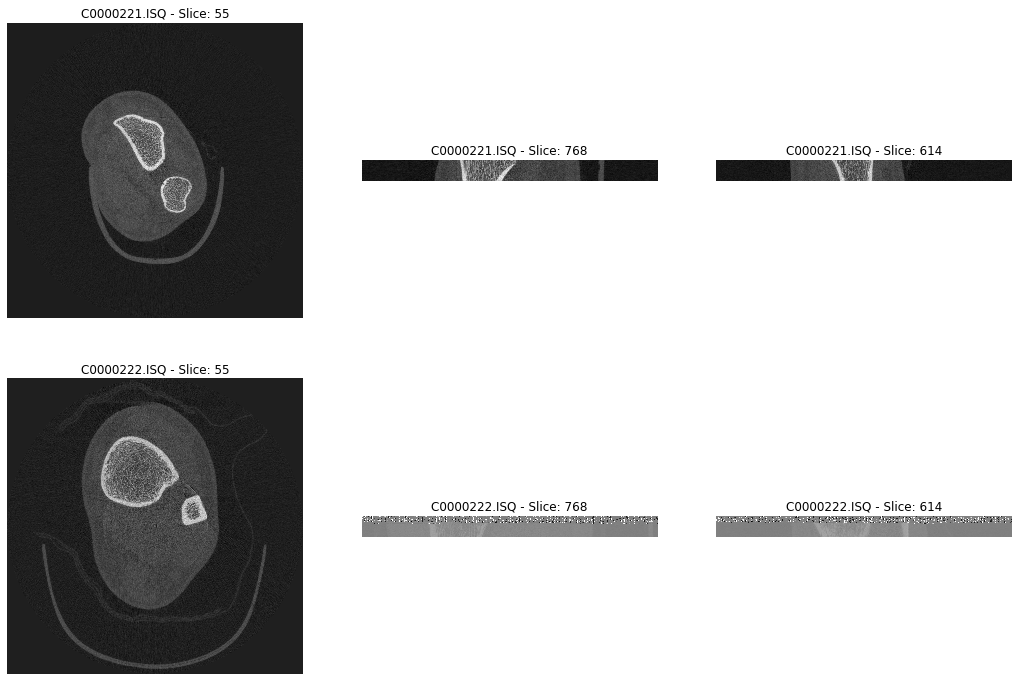

In [25]:
# parameters
n_of_images   = 2 

# creating the figure 
img_dim        = 6
figure_width  = img_dim * 3           # multiplying the dimension of one image times the 3 columns (frontal, sagittal, axial)
figure_length = img_dim * n_of_images # multiplying the dimension of one image times the number of images 
plt.rcParams['figure.figsize'] = [figure_width, figure_length] 
fig     = plt.figure()                # creating the figure
fig.tight_layout()                    # avoids subplots overlap

# subplots characteristics
n_of_columns = 3
n_of_rows    = n_of_images
axis_index   = 1

# visualizing
for i in range(0, n_of_images):
    
    # read image
    img = scanco_read_files.read_isq_image(isq_folder + isq_file_names[i])

    # get slice ids (SimpleITK format)
    slice_id_s = round(img.GetSize()[0]/2) 
    slice_id_a = round(img.GetSize()[1]/5*2) # slice at 2/5th from the top to visualize bones 
    slice_id_f = round(img.GetSize()[2]/2) 

    # show frontal slice
    np_slice = sitk.GetArrayViewFromImage(img[:,:,slice_id_f])
    ax1 = fig.add_subplot(n_of_rows,n_of_columns,axis_index)
    ax1.imshow(np_slice, 'gray', interpolation=None)
    ax1.set_title(isq_file_names[i] + " - Slice: " + str(slice_id_f))
    ax1.axis('off')
    axis_index = axis_index + 1

    # show sagittal slice 
    np_slice = sitk.GetArrayViewFromImage(img[slice_id_s,:,:])
    ax2 = fig.add_subplot(n_of_rows,n_of_columns,axis_index)
    ax2.imshow(np_slice, 'gray', interpolation=None)
    ax2.set_title(isq_file_names[i] + " - Slice: " + str(slice_id_s))
    ax2.axis('off')
    axis_index = axis_index + 1

    # show axial slice 
    np_slice = sitk.GetArrayViewFromImage(img[:,slice_id_a,:])
    ax3 = fig.add_subplot(n_of_rows,n_of_columns,axis_index)
    ax3.imshow(np_slice, 'gray', interpolation=None)
    ax3.set_title(isq_file_names[i] + " - Slice: " + str(slice_id_a))
    ax3.axis('off')
    axis_index = axis_index + 1

---
<a class="anchor" id="8"></a>
## 8. Hints  

- To check what a function does, use the keyword `help`. For example:  

In [26]:
help(scanco_viz.show_sitk_slice)

Help on function show_sitk_slice in module pymsk.scanco_viz:

show_sitk_slice(img, slice_id=-1, plane='a')
    Shows one slice of an image. Slice id and plane are optional argument
    Inputs:
        - img: 3D image (type: SimpleITK)
        - slice_id: id of the slice to visualize. It is an optional argument. If not specified, the function shows the slice in the middle of the stack (type: integer)
        - plane: radiological plane to visualize. It is an optional argument with three options:
          - "a", for axial
          - "v", for vertical
          - "h", for horizontal
          If not specified, the function shows the slice in the axial plane. (type: string)
          More information on radiological planes for .isq images here: https://github.com/JCMSK/pyMSK/blob/master/doc/img/isq_image_directions.pdf



- To check a type of a variable, use `type`. For example:  

In [27]:
type(img)

SimpleITK.SimpleITK.Image

---
<a class="anchor" id="9"></a>
## 9. Dependencies

In [28]:
%load_ext watermark
%watermark -v -m -p pymsk,pandas,SimpleITK,matplotlib,itk,ipywidgets 
%watermark -u -n -t -z

CPython 3.7.6
IPython 7.13.0

pymsk 0.1.3
pandas 1.0.3
SimpleITK 1.2.4
matplotlib 3.1.3
itk 5.1.1
ipywidgets 7.5.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
last updated: Thu Oct 08 2020 14:19:38 CEST
